In [1]:
import sys
sys.path.append('..')

In [2]:
from xy import xy
from shapely.geometry import Point


In [3]:
import networkx as nx

In [4]:
import geopandas as gpd

In [5]:
from nbhd.geometry import pointbox

In [6]:
from nbhd.data import Base

In [7]:
db = Base()

Initializing database connection...
Database connected!


In [8]:
geom = pointbox(Point(xy), 500)

In [9]:
from nbhd.geography import nn_translator

In [10]:
from shapely.geometry import MultiPolygon

In [11]:
def get_communities(db,
                    polygon,
                    footprint_threshold=250,
                    res_length_threshold=50,
                    short_threshold=50,
                    node_distance=20,
                    min_community_size = 10):
    

    # get nearest properties and buildings for given geometry
    df = db.knn('properties', 'buildings', polygon)

    # drop properties that are not in buildings
    df = df.loc[df.dist==0]

    # eliminate non-residential buildings
    building_counts = dict(df.buildings_id.value_counts())
    df['building_counts'] = df.buildings_id.apply(lambda x: building_counts.get(x,0))
    df['footprint_area'] = gpd.GeoSeries.from_wkb(df.buildings_geometry).area
    df['footprint_area_per_uprn'] = df.footprint_area / df.building_counts
    df['residential_building'] = df[
        'footprint_area_per_uprn'] < footprint_threshold
    df1 = df.loc[df.residential_building].copy()

    # get streets 
#     bdgs_multiplygn = MultiPolygon(
#         list(gpd.GeoSeries.from_wkb(df1.buildings_geometry).geometry.values))
    df2 = db.knn('properties', 'roads', 
                 polygon, 
                 t2_columns=['"startNode"', '"endNode"'])
    df2.loc[df2.properties_id.apply(lambda x: x in df1.properties_id)]

    df2 = gpd.GeoDataFrame(df2, geometry=gpd.GeoSeries.from_wkb(df2.roads_geometry))
    df2['length'] = df2.geometry.length

    # 3 establish whether roads are residential
    street_counts = dict(df2.roads_id.value_counts())
    df2['street_counts'] = df2.roads_id.apply(
        lambda x: street_counts.get(x, 0))
    df2['street_length_per_uprn'] = df2.length / df2.street_counts
    df2['residential_street'] = df2.street_length_per_uprn < res_length_threshold
    residential = dict(zip(df2.roads_id, df2.residential_street))
    df2['residential'] = df2.roads_id.apply(
        lambda x: residential.get(x, False))
    df2['short_street'] = df2.length < short_threshold
    df2['res_or_short'] = df2.residential | df2.short_street
    df3 = df2.loc[df2.res_or_short].copy()

    # 4 treat nearby nodes as equivalent
    translator = nn_translator(db, 'nodes',
        geom, node_distance)

    edges = df3.loc[~df3.duplicated()].copy()
    edges['translated_start'] = edges.startNode.apply(
        lambda x: translator.get(x, x))
    edges['translated_end'] = edges.endNode.apply(
        lambda x: translator.get(x, x))

    # 5 find connected networks of residential streets
    g = nx.from_pandas_edgelist(edges, 'translated_start',
                                'translated_end', True)
    subgraphs = [g.subgraph(c) for c in nx.connected_components(g)]
    sgs = [sg for sg in subgraphs if len(sg) > min_community_size]

    # 6 add community labels
    communities = dict()
    for i in range(len(sgs)):
        communities[str(i).zfill(2)] = list(
            nx.get_edge_attributes(sgs[i], 'roads_id').values())
    communities_key = {
        value: key
        for key, value_list in communities.items() for value in value_list
    }
    df3['community'] = df3.roads_id.apply(
        lambda x: communities_key.get(x, None))

    return df3

In [11]:
from nbhd.geography import get_communities

In [12]:
df3 = get_communities(db, geom, node_distance=10, min_community_size=1)

In [13]:
df3

,properties_id,properties_geometry,roads_id,startNode,endNode,roads_geometry,dist,geometry,length,street_counts,street_length_per_uprn,residential_street,residential,short_street,res_or_short,community
0,38010257,0101000020346C0000000000002CA5144100000000F4F4...,idA5FB42FD-5D50-4934-B38A-8DCDEC43B29B,id3B275B2E-2394-4DA2-87DD-22074226E0B1,id22CCDDDB-9D49-487E-BF31-F4D4099A688A,0102000020346C00000300000000000000D4A414410000...,12.192093,"LINESTRING (338229.000 392485.000, 338294.000 ...",144.027775,50,2.880556,True,True,False,True,00
1,38010258,0101000020346C00000000000018A514410000000080F4...,idA5FB42FD-5D50-4934-B38A-8DCDEC43B29B,id3B275B2E-2394-4DA2-87DD-22074226E0B1,id22CCDDDB-9D49-487E-BF31-F4D4099A688A,0102000020346C00000300000000000000D4A414410000...,11.831051,"LINESTRING (338229.000 392485.000, 338294.000 ...",144.027775,50,2.880556,True,True,False,True,00
2,38010259,0101000020346C0000000000003CA5144100000000FCF4...,idA5FB42FD-5D50-4934-B38A-8DCDEC43B29B,id3B275B2E-2394-4DA2-87DD-22074226E0B1,id22CCDDDB-9D49-487E-BF31-F4D4099A688A,0102000020346C00000300000000000000D4A414410000...,12.275410,"LINESTRING (338229.000 392485.000, 338294.000 ...",144.027775,50,2.880556,True,True,False,True,00
3,38010260,0101000020346C00000000000028A514410000000088F4...,idA5FB42FD-5D50-4934-B38A-8DCDEC43B29B,id3B275B2E-2394-4DA2-87DD-22074226E0B1,id22CCDDDB-9D49-487E-BF31-F4D4099A688A,0102000020346C00000300000000000000D4A414410000...,11.747734,"LINESTRING (338229.000 392485.000, 338294.000 ...",144.027775,50,2.880556,True,True,False,True,00
4,38010261,0101000020346C0000000000004CA514410000000004F5...,idA5FB42FD-5D50-4934-B38A-8DCDEC43B29B,id3B275B2E-2394-4DA2-87DD-22074226E0B1,id22CCDDDB-9D49-487E-BF31-F4D4099A688A,0102000020346C00000300000000000000D4A414410000...,12.358727,"LINESTRING (338229.000 392485.000, 338294.000 ...",144.027775,50,2.880556,True,True,False,True,00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3099,38092819,0101000020346C00000000000074A714410000000060EC...,id68CBE6D0-3407-4102-B68D-4D68423ACA05,id52181AF9-4AE6-402F-A951-3A3D7A76E93C,id037EB9A7-D855-4C56-9D14-557DAF83D750,0102000020346C0000030000000000000074A714410000...,46.009845,"LINESTRING (338397.000 391911.000, 338447.500 ...",107.563934,30,3.585464,True,True,False,True,09
3100,38092820,0101000020346C00000000000074A714410000000060EC...,id68CBE6D0-3407-4102-B68D-4D68423ACA05,id52181AF9-4AE6-402F-A951-3A3D7A76E93C,id037EB9A7-D855-4C56-9D14-557DAF83D750,0102000020346C0000030000000000000074A714410000...,46.009845,"LINESTRING (338397.000 391911.000, 338447.500 ...",107.563934,30,3.585464,True,True,False,True,09
3101,38092821,0101000020346C0000000000002CA9144100000000D4EA...,id213DDC6A-4471-4F69-A4CC-C0A4D4D4C3E2,idE87CC92E-6371-475E-92C4-15245240FA87,id446ED1EA-A94F-41F3-B3CF-8EED2C28D7CB,0102000020346C00000300000000000000C8A814410000...,24.317904,"LINESTRING (338482.000 391823.000, 338566.000 ...",184.390889,21,8.780519,True,True,False,True,00
3102,38092822,0101000020346C00000000000004A614410000000098EC...,idF0E2FDEB-5966-4B92-B303-38CACACC135A,id7B0D08AF-7B2E-4BA8-B3DB-6B1F9A5F40A7,idBC29C90E-3F16-4725-844C-CCEE50444B7E,0102000020346C000003000000000000009CA514410000...,71.000000,"LINESTRING (338279.000 392045.000, 338303.500 ...",49.000000,2,24.500000,True,True,True,True,00


<AxesSubplot:>

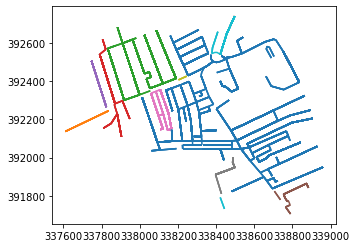

In [14]:
df3.plot('community')

In [ ]:
df3.columns

In [ ]:
# treat nearby nodes as equivalent

In [ ]:
# find connected networks of residential streets

In [ ]:
# add community labels

In [ ]:
# get some statistics

In [ ]:
def get_communities(self,
                    db,
                    geom,
                    footprint_threshold=250,
                    res_length_threshold=20,
                    short_threshold=20,
                    min_community_size=0,
                    node_distance=5):

    # nearest roads ~ 'slimroads' is without motorways and secondary roads
    nr_roads = self.db.nearest_neighbours('slimroads',
                                          self.geom.buffer(10))
    # nearest buildings
    nr_buildings = self.db.nearest_neighbours('openmaplocal',
                                              self.geom.buffer(1))
    # merge on UPRN
    df = nr_buildings.merge(nr_roads,
                            on=['UPRN', 'uprn_geometry'],
                            how='inner',
                            suffixes=('_building', '_street'))

    # 1 eliminate non-building properties : distance to building must == 0
    df1 = df.loc[df.dist_building == 0].copy()

    # 2 eliminate non-residential buildings
    building_counts = dict(df1.id_building.value_counts())
    df1['building_counts'] = df1.id_building.apply(
        lambda x: building_counts.get(x, 0))
    df1['footprint_area'] = gpd.GeoSeries(df1.geometry_building).area
    df1['footprint_area_per_uprn'] = df1.footprint_area / df1.building_counts
    df1['residential_building'] = df1[
        'footprint_area_per_uprn'] < footprint_threshold
    df2 = df1.loc[df1.residential_building].copy()

    # 3 establish whether roads are residential
    street_counts = dict(df2.id_street.value_counts())
    df2['street_counts'] = df2.id_street.apply(
        lambda x: street_counts.get(x, 0))
    df2['street_length_per_uprn'] = df2.length / df2.street_counts
    df2['residential_street'] = df2.street_length_per_uprn < res_length_threshold
    residential = dict(zip(df2.id_street, df2.residential_street))
    df['residential'] = df.id_street.apply(
        lambda x: residential.get(x, False))
    df['short_street'] = df.length < short_threshold
    df['res_or_short'] = df.residential | df.short_street
    df3 = df.loc[df.res_or_short].copy()

    # 4 treat nearby nodes as equivalent
    translator = self.db.get_nearest_nodes_translator(
        self.geom, node_distance)
    edges = df3.loc[~df3.duplicated()].copy()
    edges['translated_start'] = edges.startNode.apply(
        lambda x: translator.get(x, x))
    edges['translated_end'] = edges.endNode.apply(
        lambda x: translator.get(x, x))

    # 5 find connected networks of residential streets
    g = nx.from_pandas_edgelist(edges, 'translated_start',
                                'translated_end', True)
    subgraphs = [g.subgraph(c) for c in nx.connected_components(g)]
    sgs = [sg for sg in subgraphs if len(sg) > min_community_size]

    # 6 add community labels
    communities = dict()
    for i in range(len(sgs)):
        communities[str(i).zfill(2)] = list(
            nx.get_edge_attributes(sgs[i], 'id_street').values())
    communities_key = {
        value: key
        for key, value_list in communities.items() for value in value_list
    }

    df['community'] = df.id_street.apply(
        lambda x: communities_key.get(x, None))
    self.df = df
    return